In [9]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement, ClassicDP
from src.agents.bcd_grid import bcd, bcgd
from src.utils import Discretizer,generate_random_colors
from src.trainer import run_experiment
from src.plots import plot_gridworld
from src.models import PARAFAC

import tensorly as tl
from tensorly.decomposition import parafac

import torch
from tensorly.tenalg import khatri_rao

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import pickle


RANK ANALISYS FOR Q*

In [10]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño, nA=5)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[Tamaño,Tamaño],
    min_points_actions=[0],
    max_points_actions=[4],
    bucket_actions=[5],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

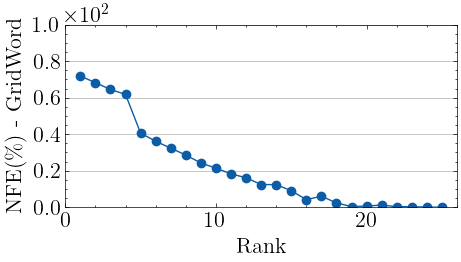

<Figure size 350x262.5 with 0 Axes>

In [3]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(Q_opt, None, 40)

POLICY EVALUATION WITH BCD

In [13]:
k_list = [15,25,30]
scale = 1
num_iter = 500

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs, Q = bcd_inv.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

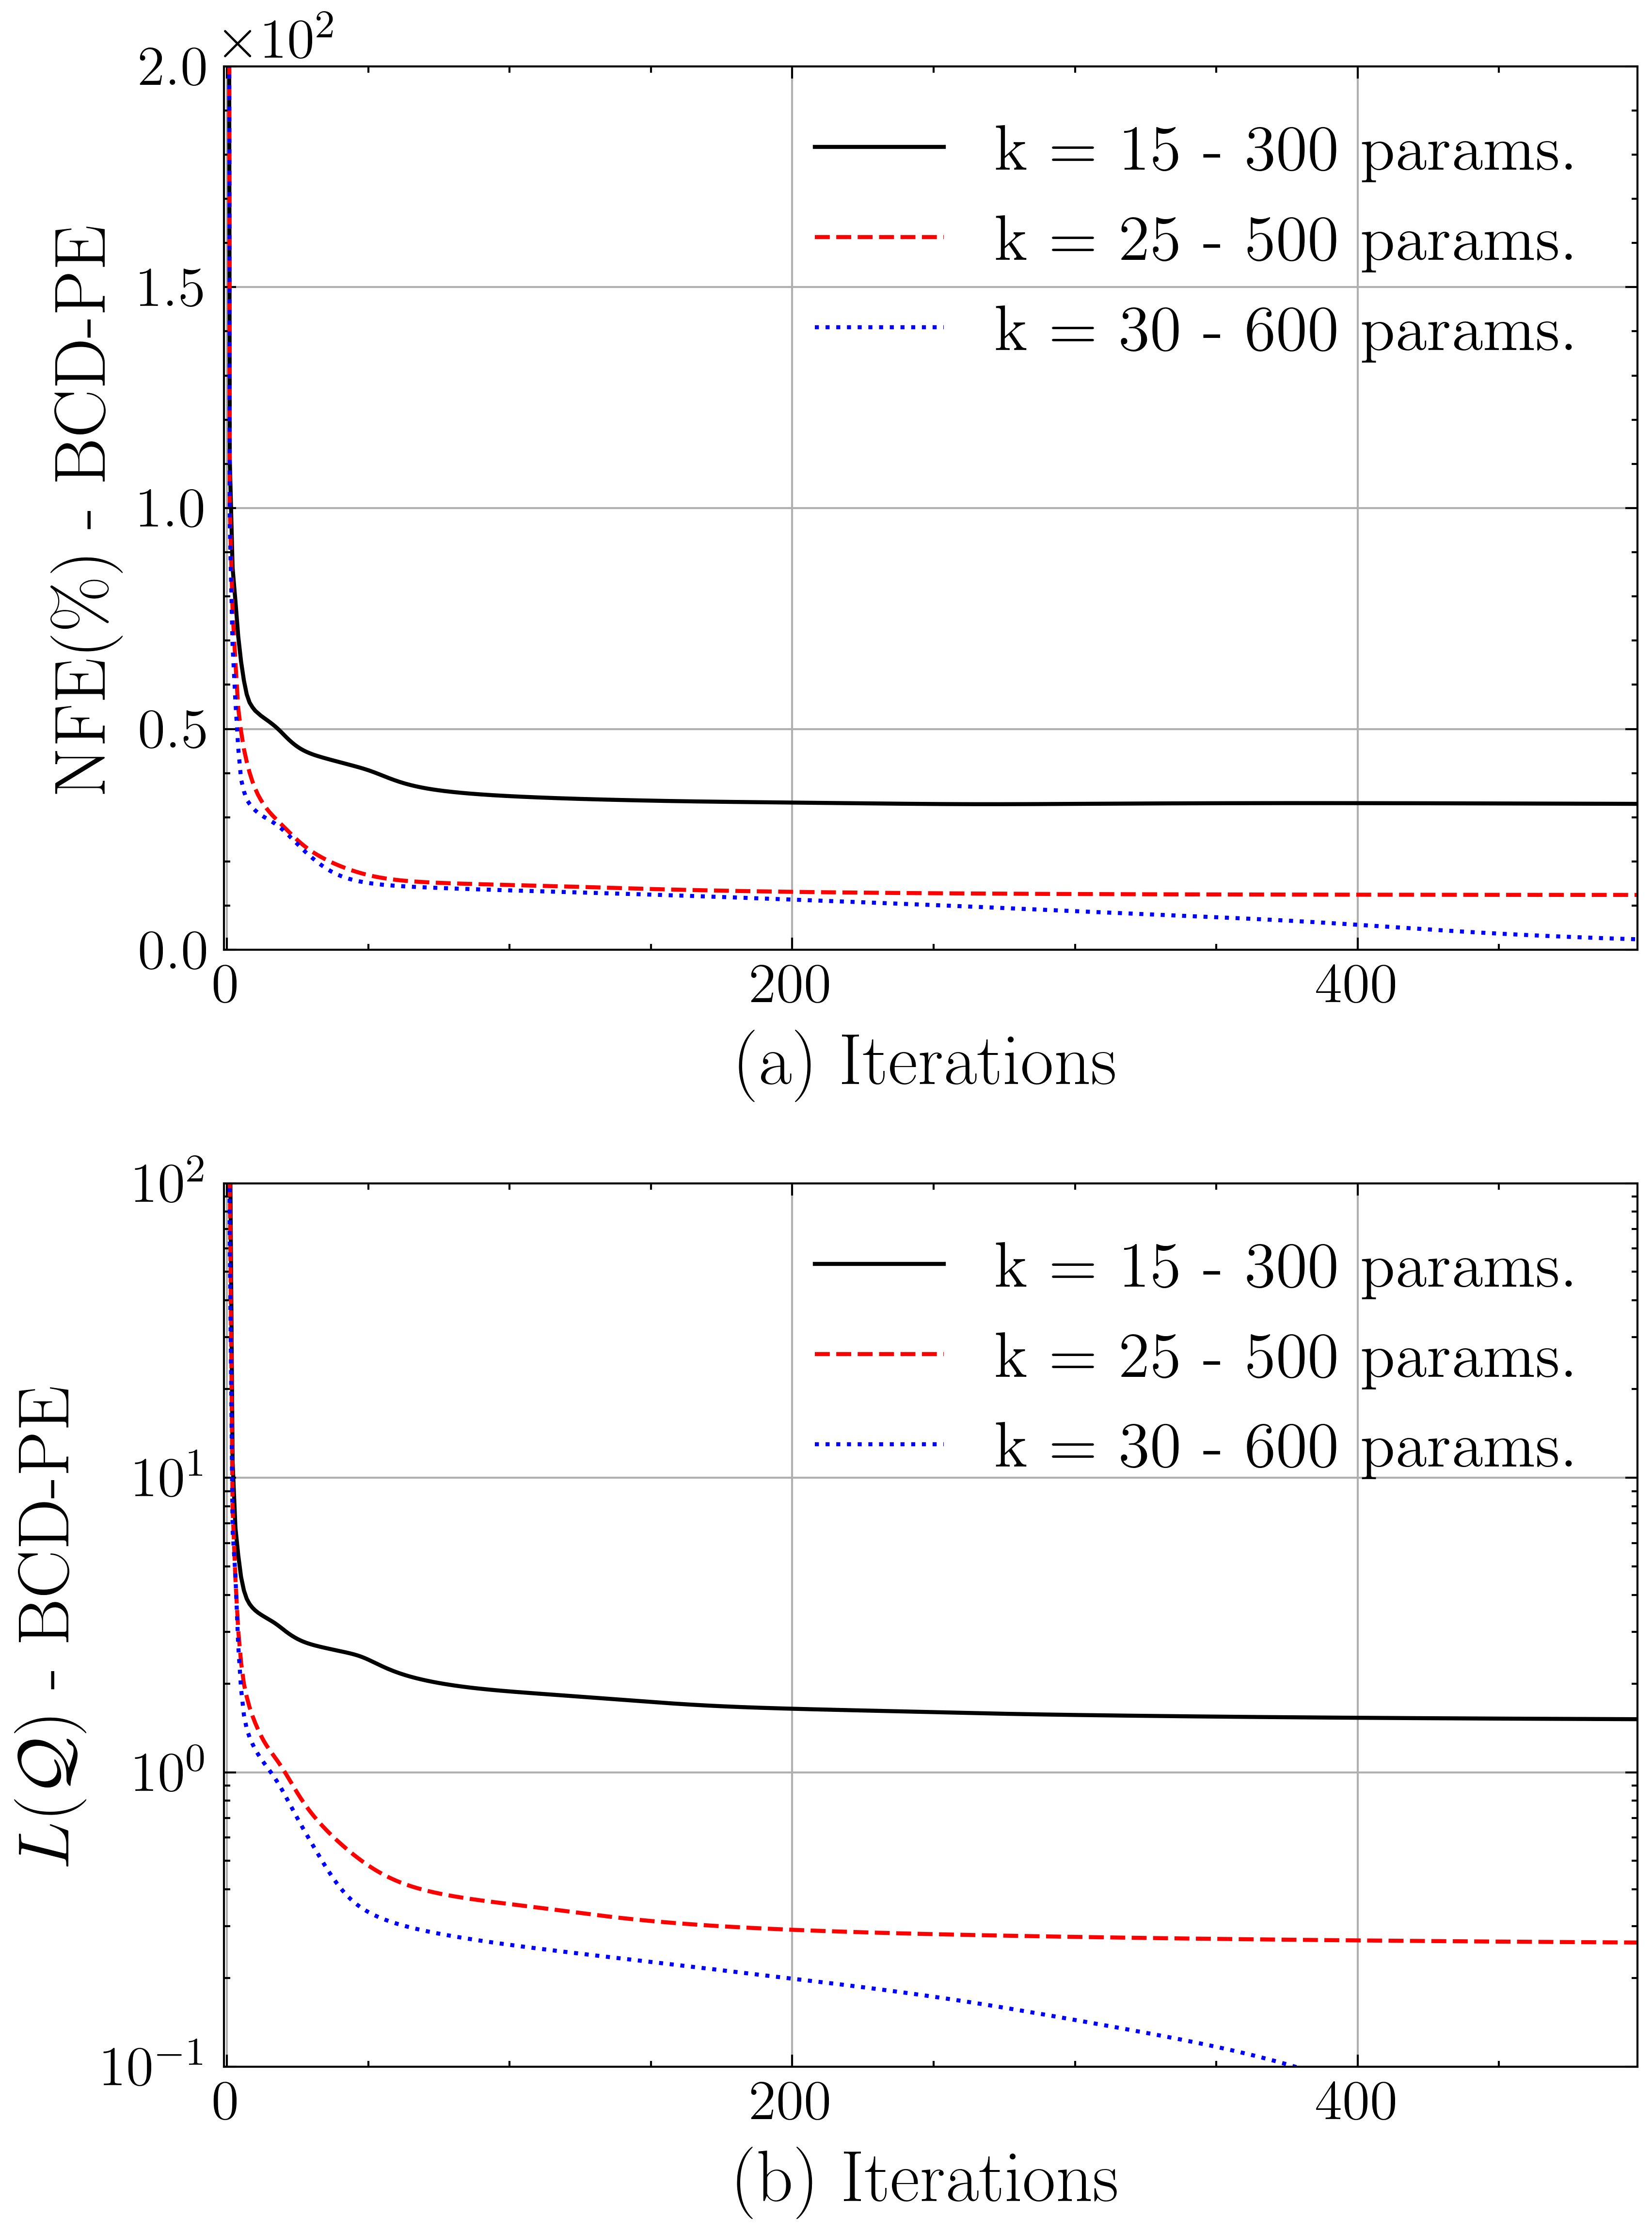

In [18]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6, 8])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-1, num_iter-1)
        axes[0].set_ylim(0, 200)
        #axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(-1, num_iter-1)
        axes[1].set_ylim(0.1, 100)
        #axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCD-PE ",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PE-vertical")
    # Mostrar la figura
    plt.show()

POLICY EVALUATION WITH BCGD

In [21]:
# GridWorld
k_list = [30]
scale = 0.5
num_iter = 2000
alpha = 10e-3

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA),alpha)

    fo_values,errors,convs, Q = bcd_grad.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

In [19]:
with open('exp_000.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]

fo_list.pop(1)
errors_list.pop(1)
conv_list.pop(1)

k_list = [15, 25, 30]
num_iter = 100000

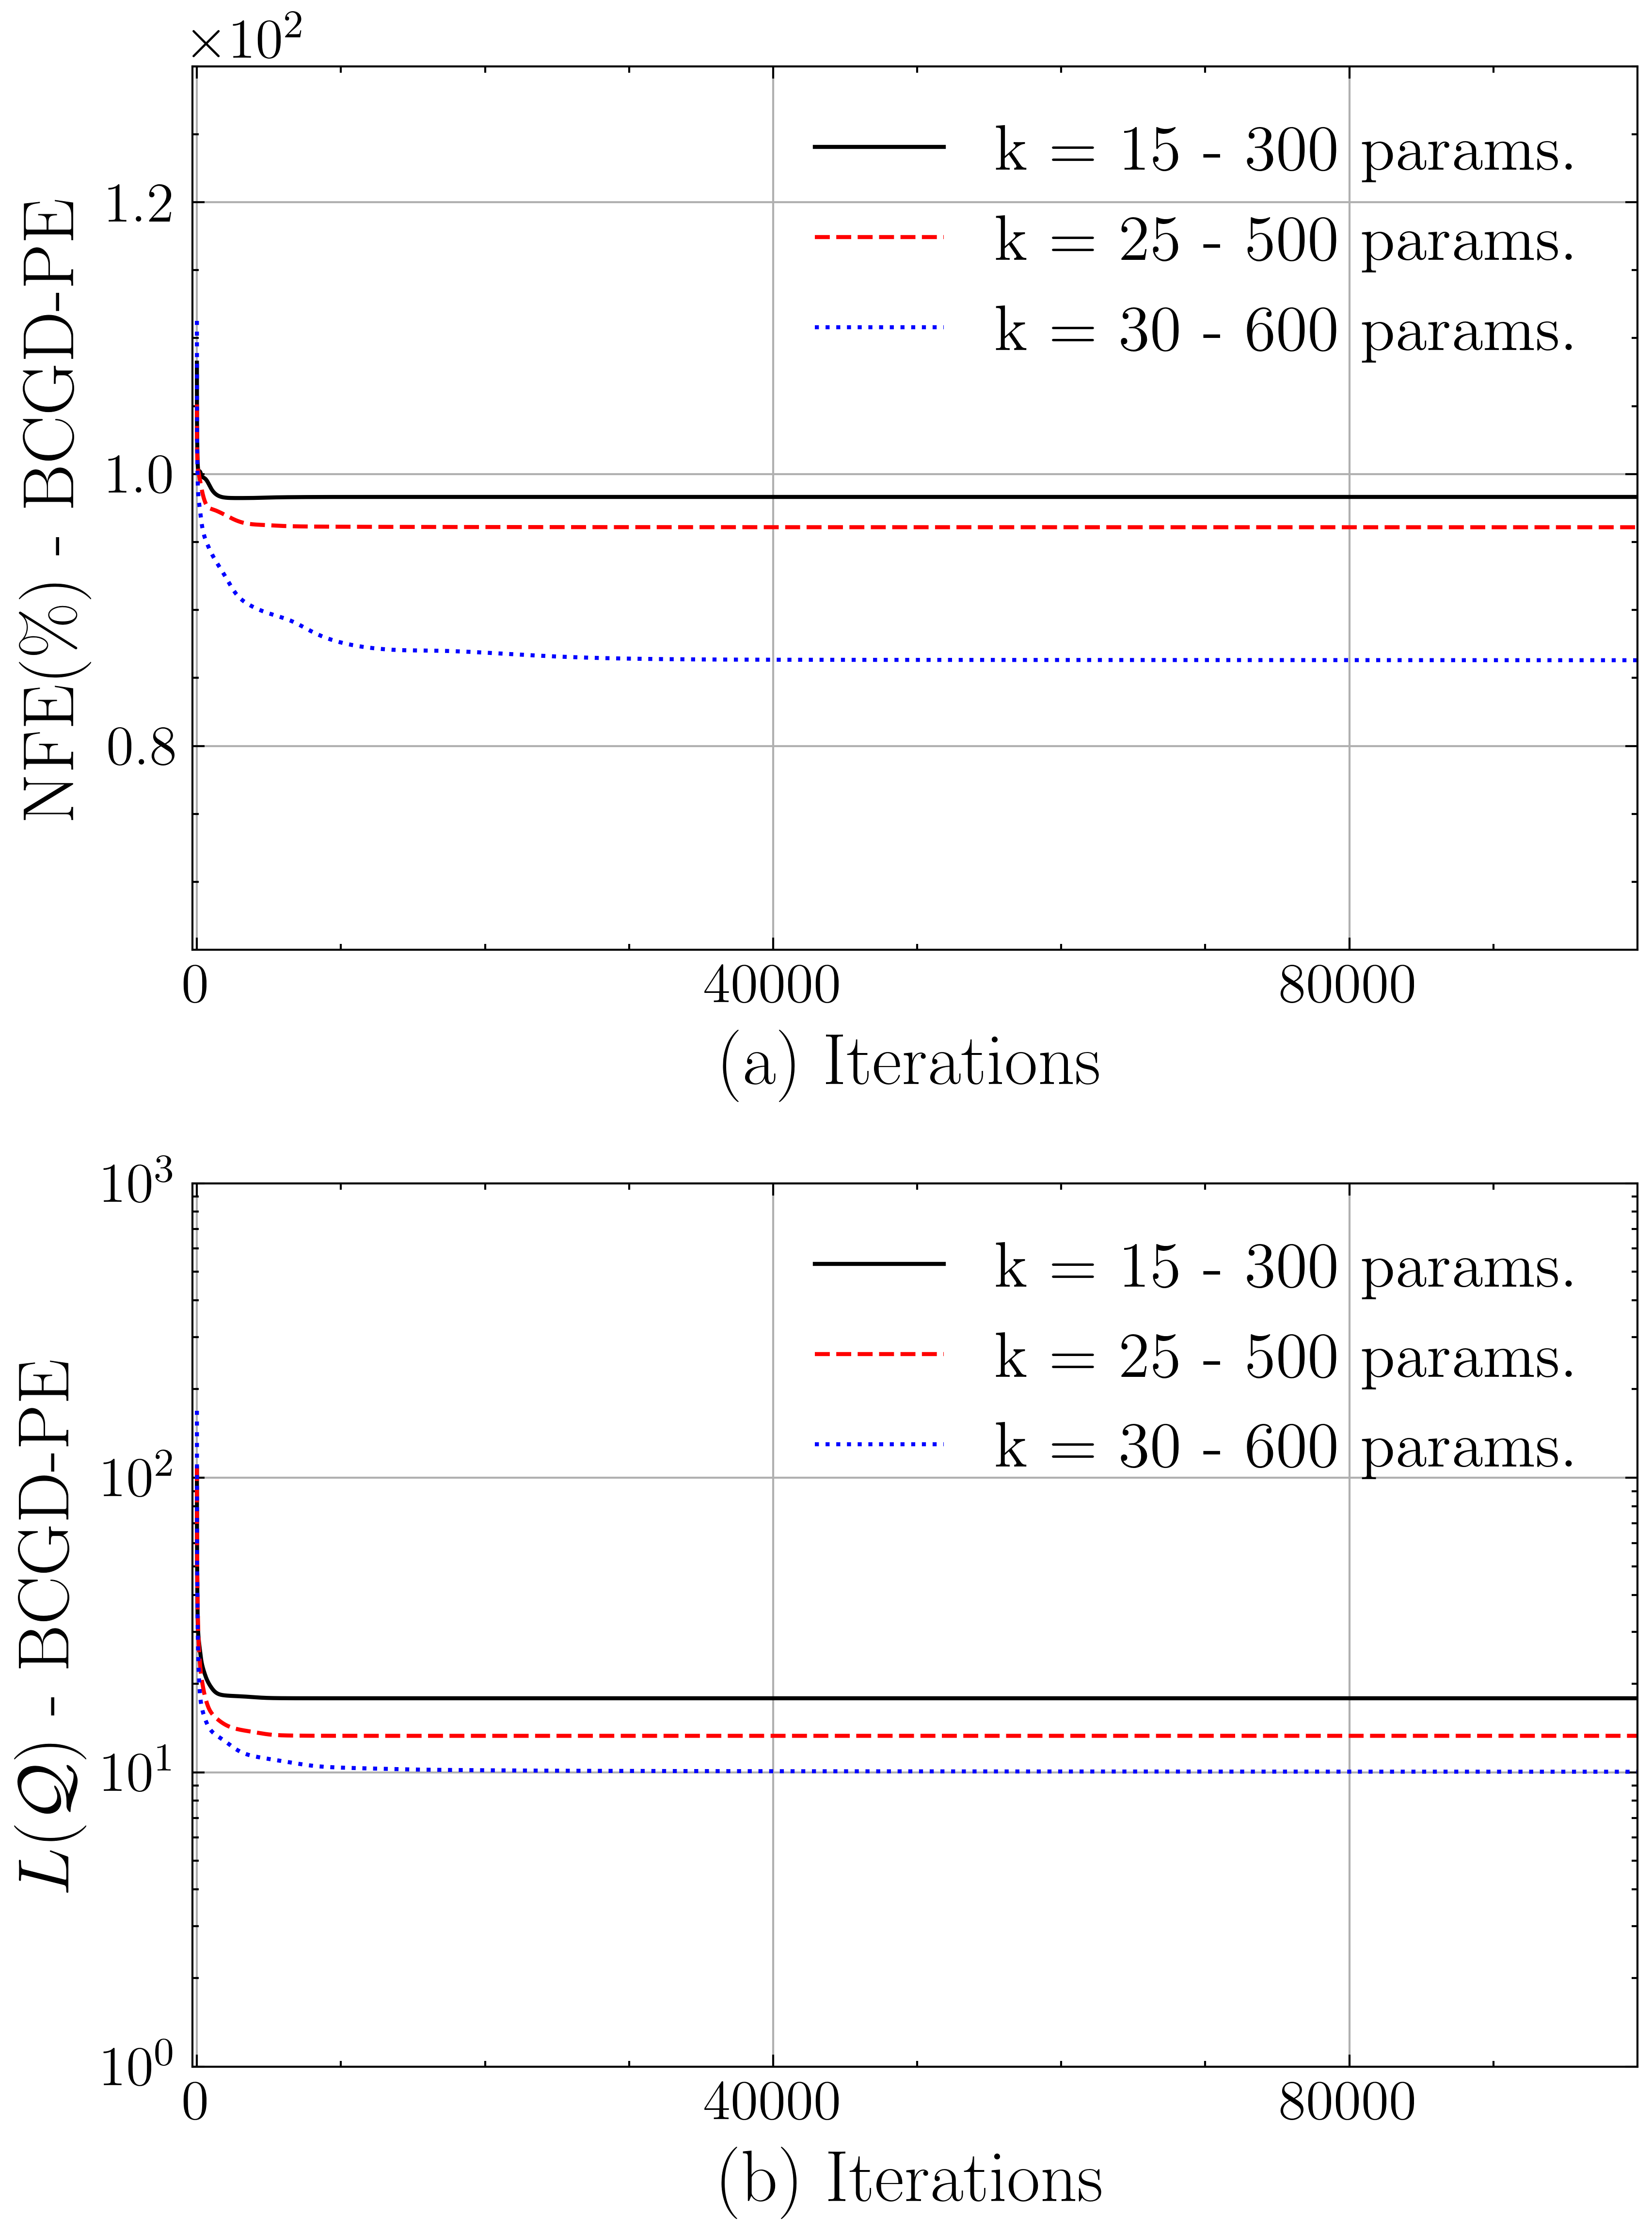

In [20]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6, 8])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-300, num_iter -1)
        axes[0].set_ylim(65, 130)
        #axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        #axes[1].set_xlim(-300, num_iter-1)
        axes[1].set_ylim(1, 1000)
        axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCGD-PE",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PE-vertical")
    # Mostrar la figura
    plt.show()

BCD - Policy Evaluation

In [21]:
k_list = [15, 25, 30]
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [22]:
G_list = []
Policy_opt = Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA)
for i in range(10000):
    G = 0
    s, _ = ENV.reset()
    for h in range(ENV.H):
        s1, s2 = s
        dist = Policy_opt[h, s2, s1,:]
        a = [np.argmax(dist)]
        s, r, d, _, _ = ENV.step(a)
        G += r

        if d:
            break
    G_list.append(G)

opt_mean_return = np.mean(G_list)
print(opt_mean_return)

1.0


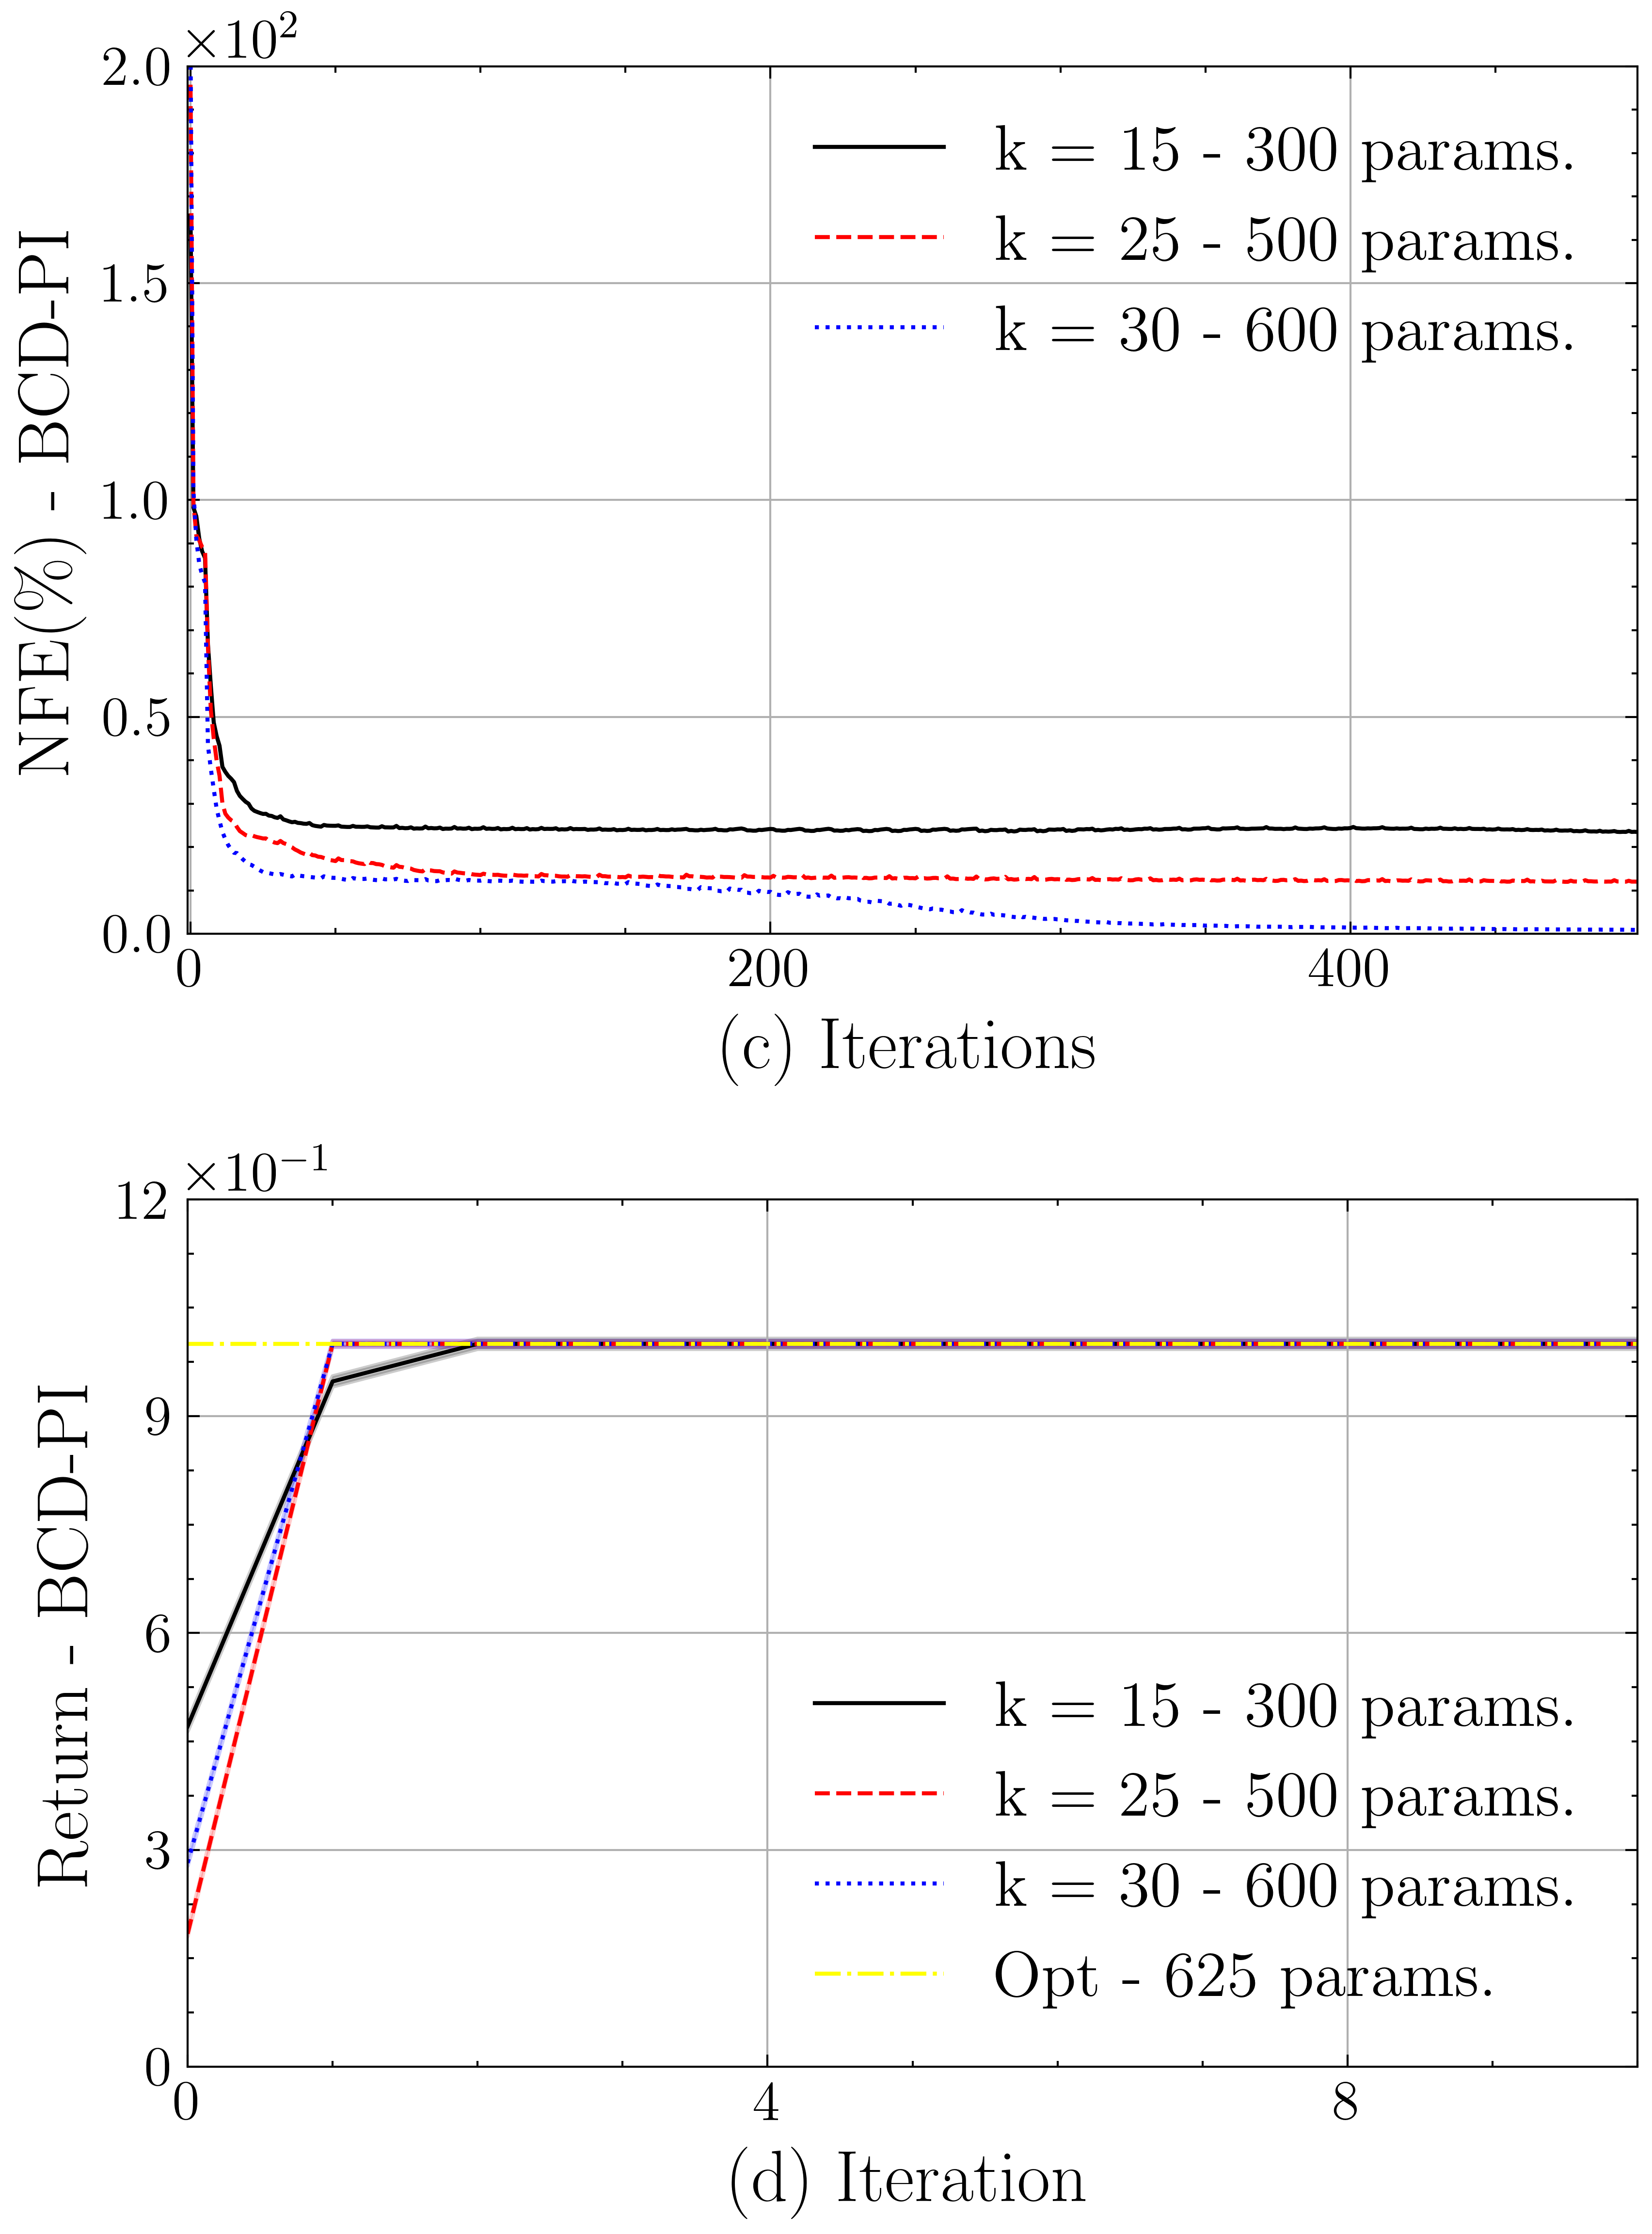

In [23]:
colors = ["Black","Red","Blue","Green"]
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6, 8])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-1, x_lim -1)
        axes[0].set_ylim(0, 200)
        #axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        #axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Return - BCD-PI",fontsize=18)
        axes[1].legend(loc='lower right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter, color = "yellow", label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(0, 10)
    axes[1].set_ylim(0, 1.2)
    axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Return - BCD-PI",fontsize=18)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PI-vertical")
    # Mostrar la figura
    plt.show()

In [ ]:
k_list = [10, 20, 30, 50]
scale = 0.5
bcd_num_iter = 50
policy_num_iter = 2000
alpha = 10e-4

fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA),alpha)
    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_grad.bcgd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [24]:
with open('results/exp_11111.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

fo_list.pop(1)
errors_list.pop(1)
conv_list.pop(1)
returns_mean_list.pop(1)
returns_std_list.pop(1)

k_list = [15, 25, 30]
scale = 0.5
bcd_num_iter = 50
policy_num_iter = 2000
alpha = 10e-3

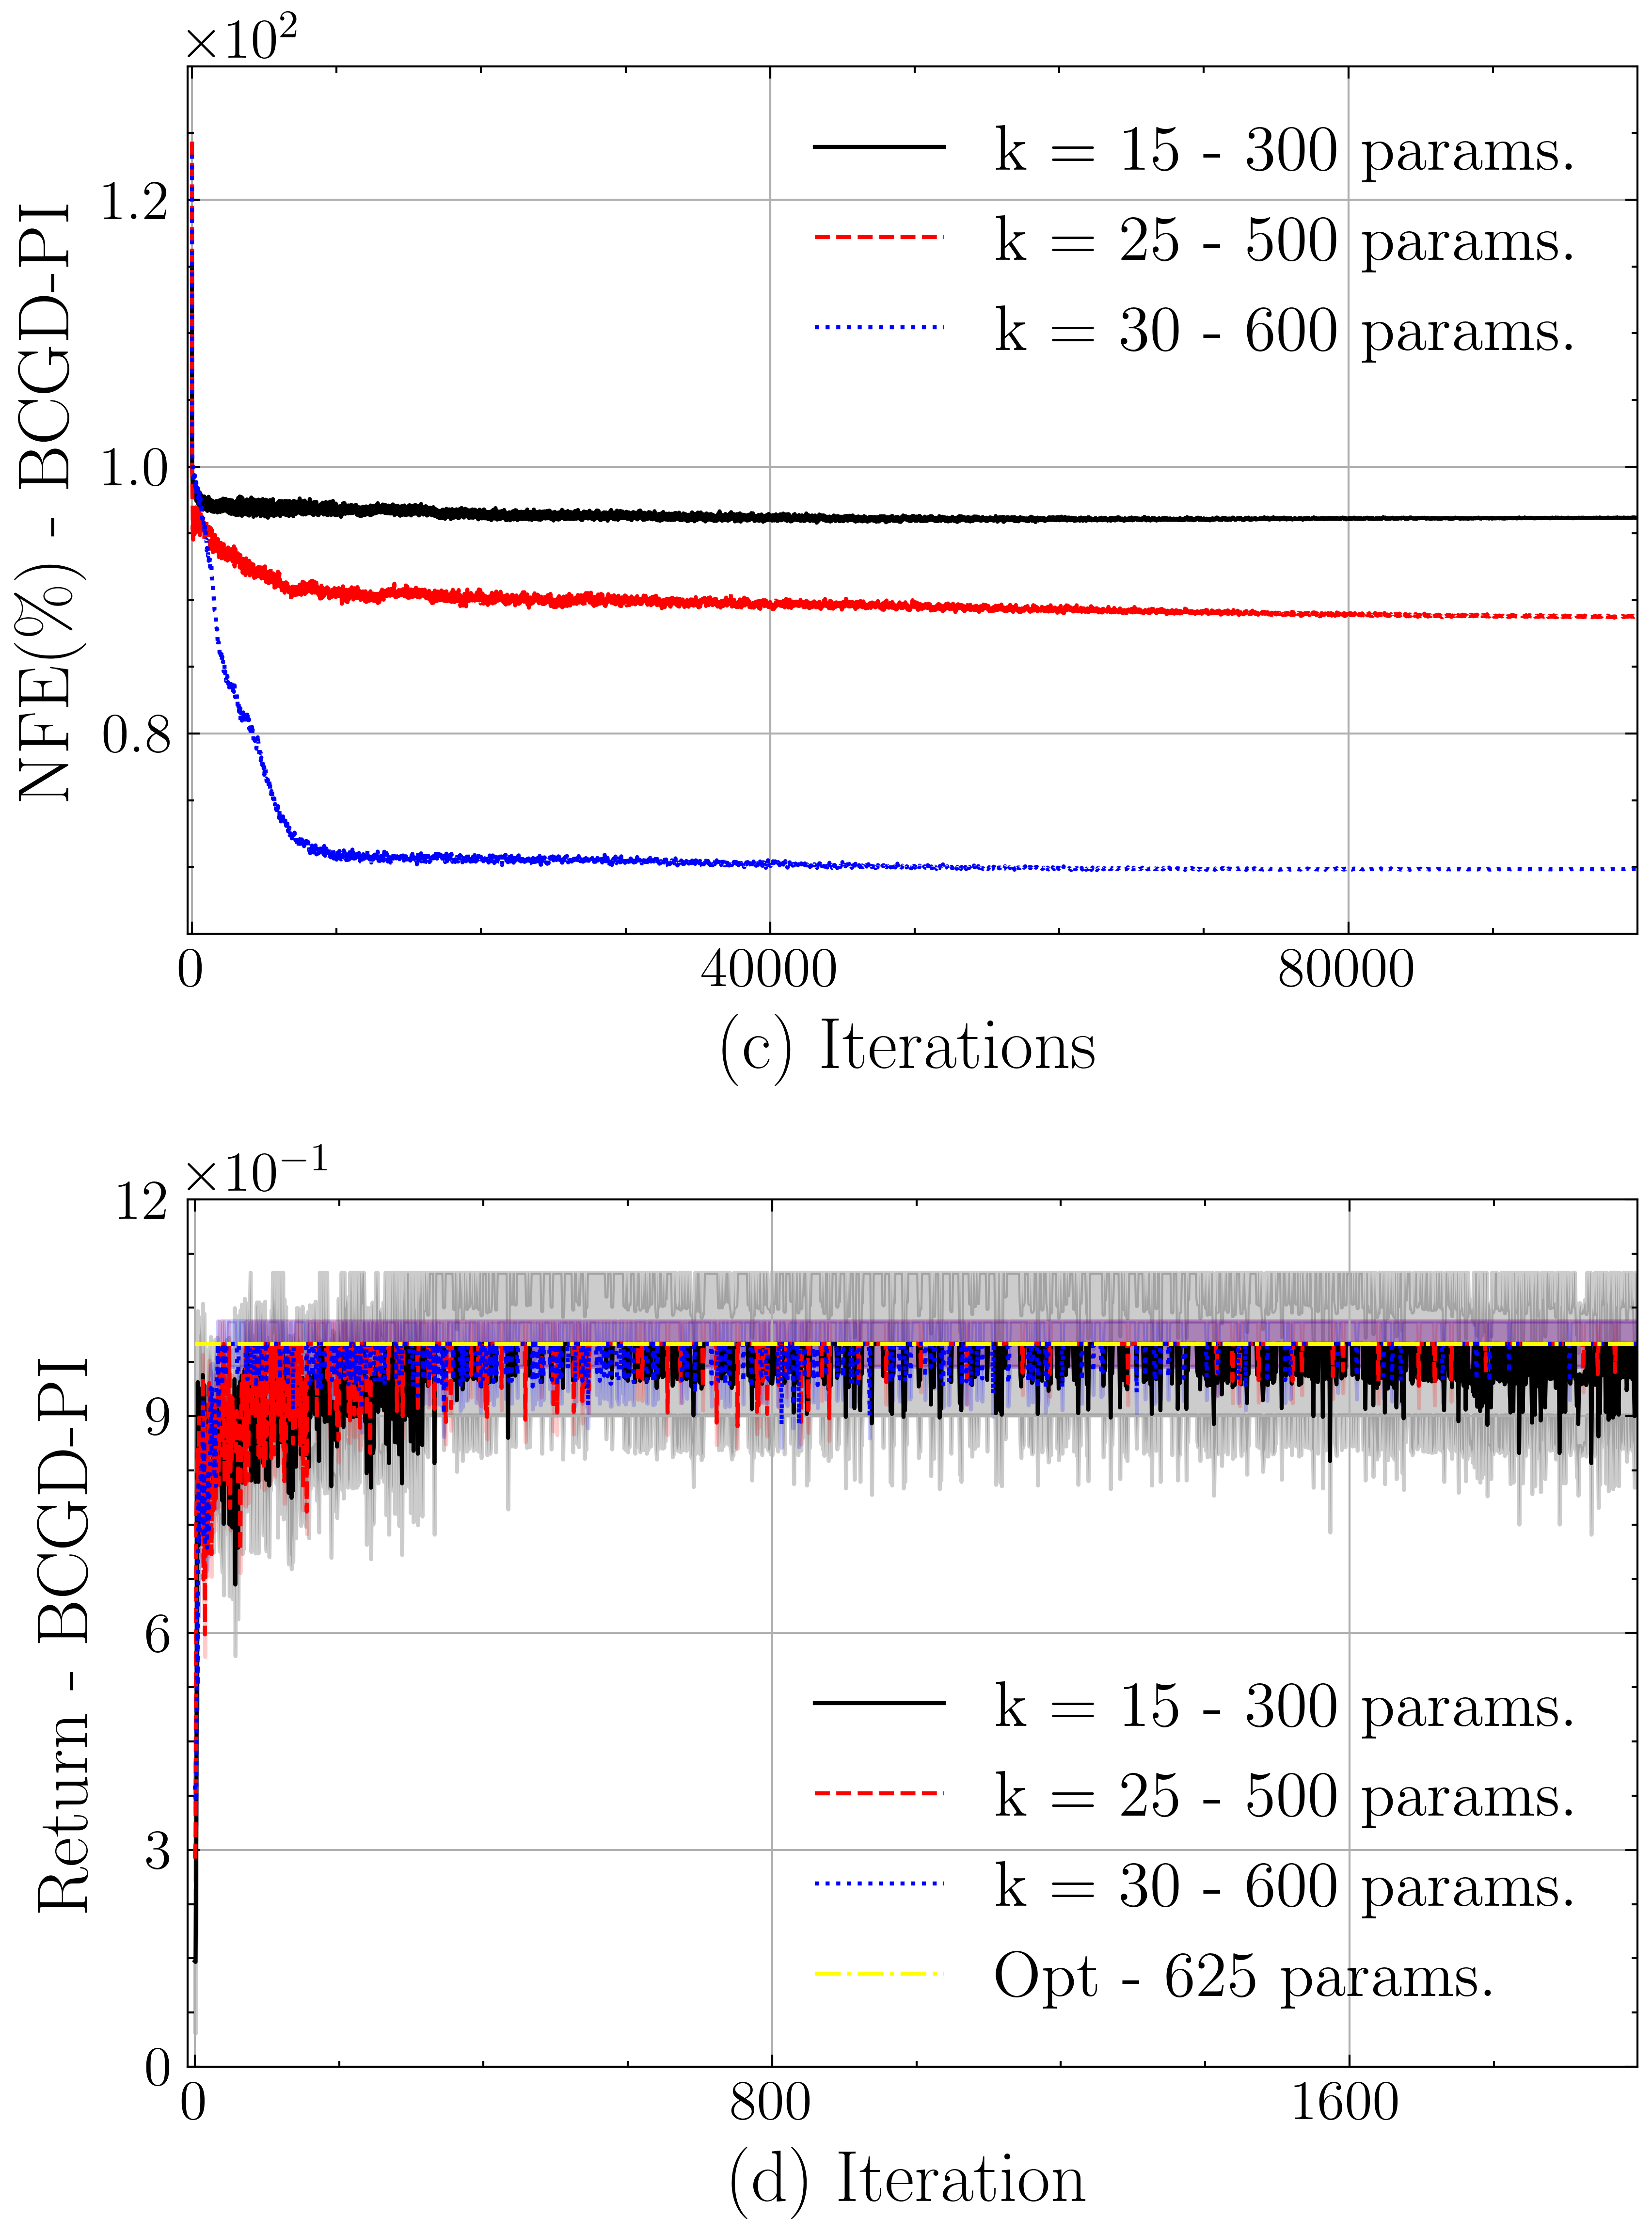

In [25]:
colors = ["Black","Red","Blue","Green"]
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6, 8])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-300, x_lim -1)
        axes[0].set_ylim(65, 130)
        axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(-1, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Return  - BCGD-PI",fontsize=18)
        axes[1].legend(loc='upper right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter , color = 'yellow', label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(-10, policy_num_iter - 1)
    axes[1].set_ylim(0, 1.2)
    axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Return - BCGD-PI ",fontsize=18)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PI-vertical")
    # Mostrar la figura
    plt.show()
    

Plot de las matrices

In [11]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño,nA=5)

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[4],
    bucket_actions=[5],
)

k = 50
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

Q = PARAFAC(
        np.concatenate(
            [[ENV.H], DISCRETIZER.bucket_states, DISCRETIZER.bucket_actions]
        ),
        k=k,
        scale= scale,
        nA=len(DISCRETIZER.bucket_actions),
).double()

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)
clasic = ClassicDP(ENV.nS,ENV.nA,ENV.R,ENV.P,gamma = 1)
bcd_inv = bcd(Q,Pi,DISCRETIZER,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

_ = bp_learner.run()
_ = clasic.run_value_iter()
_,_,_,_,_, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)



In [14]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.ticker import ScalarFormatter
from PIL import Image
from matplotlib import cm

import tensorly as tl
from tensorly.decomposition import parafac

def plot_gridworld(W, mat_q_stationary, mat_q, mat_tlr,Q_list):

    plot_gridworld_Q(W, mat_q_stationary, mat_q, mat_tlr)
    plot_gridwolrd_R(W)
    draw_grid_with_arrows(Q_list)
    # Lista de imágenes
    fotos = ["figures/fig_R.jpg", "figures/fig_Q_right.jpg", "figures/arrows.jpg", "figures/cmap.jpg"]
    output="figures/Q2.jpg"
    # Cargar las imágenes
    imagenes = [Image.open(foto) for foto in fotos]

    # Obtener el tamaño máximo de cada fila y columna
    ancho_total = int(imagenes[0].size[0] + imagenes[2].size[0]/3 + imagenes[3].size[0])
    alto_total = imagenes[0].size[1] * 2

    # Crear un lienzo vacío para el mosaico
    mosaic = Image.new("RGB", (ancho_total, alto_total))

    # Colocar las imágenes en el lienzo
    mosaic.paste(imagenes[0], (0, 0))  # Esquina superior izquierda
    #mosaic.paste(imagenes[1], (imagenes[0].size[0], 0))  # Esquina superior derecha
    mosaic.paste(imagenes[2], (imagenes[0].size[0], 0))  # Esquina inferior derecha
    mosaic.paste(imagenes[2], (0, imagenes[0].size[1]))  # Esquina inferior derecha
    mosaic.paste(imagenes[3], (imagenes[0].size[0] + int(imagenes[2].size[0]/3), int(imagenes[0].size[1] - imagenes[3].size[1]/2)))  # Esquina inferior derecha
    

    # Guardar o mostrar el mosaico
    mosaic.save(output)
    mosaic.show()

def plot_gridwolrd_R(W):
    mat_r = np.zeros((W, W))
    mat_r[0, 0] = 1
    mat_r[0, -1] = 1
    mat_r[-1, 0] = 1
    mat_r[-1, -1] = 1

    # Usar estilo
    with plt.style.context(["science", "ieee"]):
        matplotlib.rcParams.update({"font.size": 16})

        # Crear una fila de subplots
        fig, axarr = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

        vmin = 0.0
        vmax = 1.0

        # Primer gráfico (mat_r)
        cax1 = axarr.imshow(mat_r, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_r[i, j], 3)
                axarr.text(j, i, v, ha="center", va="bottom", color="silver")
        axarr.set_xlabel("(a)", fontsize=16)

        axarr.set_xticks([])
        axarr.set_yticks([])

    fig.savefig("figures/fig_R.jpg", dpi=300)
    plt.clf()

def plot_gridworld_Q(W, mat_q_stationary, mat_q, mat_tlr):
    mat_r = np.zeros((W, W))
    mat_r[0, 0] = 1
    mat_r[0, -1] = 1
    mat_r[-1, 0] = 1
    mat_r[-1, -1] = 1

    # Usar estilo
    with plt.style.context(["science", "ieee"]):
        matplotlib.rcParams.update({"font.size": 16})

        # Crear una fila de subplots
        fig, axarr = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

        vmin = 0.0
        vmax = 1.0

        # Primer gráfico (mat_r)
        """cax1 = axarr[0].imshow(mat_r, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_r[i, j], 3)
                axarr[0].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[0].set_title("(a)", fontsize=14)"""

        # Segundo gráfico (mat_q_stationary)
        axarr[0].imshow(mat_q_stationary, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_q_stationary[i, j], 3)
                axarr[0].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[0].set_title("(b)", fontsize=16)

        # Tercer gráfico (mat_q)
        axarr[1].imshow(mat_q, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_q[i, j], 3)
                axarr[1].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[1].set_title("(c)", fontsize=16)

        # Cuarto gráfico (mat_tlr)
        axarr[2].imshow(mat_tlr, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_tlr[i, j], 3)
                axarr[2].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[2].set_title("(d)", fontsize=16)

        # Ajustar los ejes
        for ax in axarr:
            ax.set_xticks([])
            ax.set_yticks([])

        # Guardar y mostrar la figura
        fig.savefig("figures/fig_Q_right.jpg", dpi=300)
        plt.clf()


def plot_wireless():
    dqn = np.load("results/dqn.npy")
    dfhqn = np.load("results/dfhqn.npy")
    fhtlr = np.load("results/fhtlr.npy")
    ql = np.load("results/ql.npy")

    mu_dqn = np.mean(dqn, axis=0)
    mu_dfhqn = np.mean(dfhqn, axis=0)
    mu_fhtlr = np.mean(fhtlr, axis=0)
    mu_ql = np.mean(ql, axis=0)

    w = 100

    mu_dqn_smt = [np.mean(mu_dqn[i - w : i]) for i in range(w, len(mu_dqn))]
    mu_dfhqn_smt = [np.mean(mu_dfhqn[i - w : i]) for i in range(w, len(mu_dfhqn))]
    mu_fhtlr_smt = [np.mean(mu_fhtlr[i - w : i]) for i in range(w, len(mu_fhtlr))]
    mu_ql_smt = [np.mean(mu_ql[i - w : i]) for i in range(w, len(mu_ql))]

    with plt.style.context(["science"], ["ieee"]):
        matplotlib.rcParams.update({"font.size": 16})

        fig = plt.figure(figsize=[8, 3])
        plt.plot(mu_dqn_smt, c="b", label="DQN")
        plt.plot(mu_dqn, alpha=0.2, c="b")
        plt.plot(mu_dfhqn_smt, c="orange", label="DFHQN")
        plt.plot(mu_dfhqn, alpha=0.2, c="orange")
        plt.plot(mu_fhtlr_smt, c="g", label="FHTLR")
        plt.plot(mu_fhtlr, alpha=0.2, c="g")
        plt.plot(mu_ql_smt, c="k", label="FHQ-learning")
        plt.plot(mu_ql, alpha=0.2, c="k")
        plt.xlim(0, 100_000)
        plt.ylim(-3, 1.6)
        plt.grid()
        plt.legend()
        plt.xlabel("Episodes")
        plt.ylabel("Return")
        fig.savefig("figures/fig_2.jpg", dpi=300)

def plot_errors(errors,name):
    plt.stem(errors, basefmt=" ")
    plt.title("Error"+ name + "Iteration")
    plt.xlabel("Iteracion")
    plt.ylabel("Error")
    plt.grid(True)
    plt.savefig("figures/"+name+"errors")
    plt.clf()

def plot_tensor_rank(Q_to_plot,name,max_rank =  25):
    
    tensor = Q_to_plot - np.mean(Q_to_plot)
    norm_frobenius_original_tensor = np.linalg.norm(tensor)
    factors = []
    normlaized_errors = []
    for i in range(1,max_rank):

        factor =  parafac(tensor, rank=i)
        factors.append(factor)
        reconstructed_tensor = tl.cp_to_tensor(factor)
        normlaized_errors.append(np.linalg.norm(tensor-reconstructed_tensor)/(norm_frobenius_original_tensor/100))
        if normlaized_errors[-1] < 10e-9:
            break

    rangos = np.arange(1, len(normlaized_errors)+1)  # Rango del 1 al 10
    error = np.array(normlaized_errors)  # Errores aleatorios para cada rango


    with plt.style.context(["science"], ["ieee"]):
        matplotlib.rcParams.update({"font.size": 16})

        fig = plt.figure(figsize=[5, 4])
        plt.plot(rangos, error, marker='o')

        # Configurar notación científica en los ejes
        ax = plt.gca()  # Obtener el objeto del eje actual
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

        plt.locator_params(axis='y', nbins=5)  # 5 líneas en el eje Y

        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))  # Habilitar notación científica

        plt.ylim(0, 100)
        plt.xlim(0,len(error)+1)
        plt.xlabel("Rank")
        plt.ylabel("NFE(\%) - GridWord")
        plt.grid(True,axis='y')
        plt.tight_layout()
        if name is None:
            plt.show()
        else:
            plt.savefig("figures/"+name+"errors")
        plt.clf()

def find_max_positions(array):
    # Encontrar el valor máximo
    max_value = np.max(array)
    
    # Encontrar las posiciones donde el array es igual al valor máximo
    posiciones = np.where(array == max_value)[0]  # Devuelve un array con índices

    # Convertir las posiciones a una lista
    return posiciones

def draw_grid_with_arrows(Q_list):
    cmap = cm.get_cmap('Reds')

    # Extraer colores del colormap
    red_from_cmap = cmap(1.0)  # Rojo oscuro
    white_from_cmap = cmap(0)  # Blanco o color claro

    # Configuración de la figura
    fig, ax = plt.subplots(1, len(Q_list), figsize=(12, 4), constrained_layout=True)

    # Coordenadas de las flechas para la cuadrícula 5x5
    grid_size = 5
    x = np.arange(grid_size)
    y = np.arange(grid_size)

    # Flechas en todas las direcciones
    directions = [(0, 0.3), (-0.3, 0), (0, -0.3), (0.3, 0)]  # (dx, dy) arriba, abajo, derecha, izquierda
    xlabel = ["b", "c", "d"]
    # Dibujar las 3 imágenes
    for idx, ax_idx in enumerate(ax):
        Q2print = Q_list[idx]
        ax_idx.set_xlim(-0.5, grid_size - 0.5)
        ax_idx.set_ylim(-0.5, grid_size - 0.5)
        ax_idx.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax_idx.set_xlabel(f"({xlabel[idx]})", fontsize=16)

        # Dibujar flechas en cada celda
        for i in range(grid_size):
            for j in range(grid_size):
                if not((i == 0 and j == 4) or (i == 4 and j == 0) or (i == 4 and j == 4) or (i == 0 and j == 0)):
                    intensity = np.max(Q2print[i, 4 - j, :])
                    rect = plt.Rectangle((i - 0.5, j - 0.5), 1, 1, color=cmap(intensity), alpha=1)
                    ax_idx.add_patch(rect)

                    direction_ids = find_max_positions(Q2print[i, 4 - j, :])
                    for dir_id in direction_ids:
                        if dir_id != 4:
                            dx, dy = directions[dir_id]
                            ax_idx.arrow(i, j, dx, dy, head_width=0.05, head_length=0.05, fc='grey', ec='grey', alpha=0.7)
                        else:
                            ax_idx.plot(i, j, 'o', color='grey', markersize=6, alpha=0.7)
                else:
                    rect = plt.Rectangle((i - 0.5, j - 0.5), 1, 1, color=white_from_cmap, alpha=1)
                    ax_idx.add_patch(rect)
                    ax_idx.plot(i, j, 'o', color='grey', markersize=6, alpha=0.7)


    plt.savefig("figures/arrows.jpg", dpi=300)



In [ ]:
mat_classic = np.max(clasic.Q, axis=1).reshape(ENV.W,ENV.W)
mat_dp = np.max(bp_learner.Q[3,:], axis=1).reshape(ENV.W,ENV.W)
mat_pi = np.max(tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors])),axis=3)[3].reshape(ENV.W, ENV.W)

Q_clasic = np.transpose(clasic.Q.reshape(ENV.W,ENV.W,ENV.nA),[1,0,2])
Q_bp = np.transpose(bp_learner.Q[3,:].reshape(ENV.W,ENV.W,ENV.nA),[1,0,2])
Q_pi = np.round(np.transpose(tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))[3,:],[1,0,2]),2)

plot_gridworld(ENV.W, mat_classic, mat_dp, mat_pi,[Q_clasic,Q_bp,Q_pi])

/tmp/ipykernel_402014/3538115435.py:237: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


In [134]:
def draw_cmap():  
    cmap = cm.get_cmap('Reds')
    fig, axarr = plt.subplots(1, 1, figsize=(1, 4), constrained_layout=True)
    axarr.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for spine in axarr.spines.values():
        spine.set_visible(False)
    # Usar estilo
    with plt.style.context(["science", "ieee"]):
        plt.rcParams.update({'font.size': 14})  # Cambiar globalmente el tamaño de la fuente de la figura
        # Crear un eje específico para la barra de colores
        cax = fig.add_axes([0, 0.2, 0.3, 0.87])  # [left, bottom, width, height]
        
        # Añadir la barra de colores
        norm = plt.Normalize(vmin=0, vmax=1)  # Normalizar el rango de intensidades (0 a 1)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Se requiere para crear la barra de colores
        cbar = fig.colorbar(sm, cax=cax)

        # Etiqueta de la barra de colores
        cbar.set_label("Expecetd Return", fontsize=16)
        fig.savefig("figures/cmap.jpg", dpi=300)
        plt.clf()

draw_cmap()

/tmp/ipykernel_1683831/2050256900.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


In [7]:
def plot_vertical():

    # Lista de imágenes
    fotos = ["figures/BCD-PE-vertical.png", "figures/BCD-PI-vertical.png", "figures/BCGD-PE-vertical.png", "figures/BCGD-PI-vertical.png"]
    output="figures/PI-PE-vertical.jpg"
    # Cargar las imágenes
    imagenes = [Image.open(foto) for foto in fotos]

    # Obtener el tamaño máximo de cada fila y columna
    ancho_total = imagenes[0].size[0] + imagenes[3].size[0]
    alto_total = imagenes[0].size[1] + imagenes[2].size[1]

    # Crear un lienzo vacío para el mosaico
    mosaic = Image.new("RGB", (ancho_total, alto_total))

    # Colocar las imágenes en el lienzo
    mosaic.paste(imagenes[0], (0, 0))  # Esquina superior izquierda
    #mosaic.paste(imagenes[1], (imagenes[0].size[0], 0))  # Esquina superior derecha
    mosaic.paste(imagenes[2], (imagenes[0].size[0], 0))  # Esquina inferior derecha
    mosaic.paste(imagenes[1], (0, imagenes[0].size[1]))  # Esquina inferior derecha
    mosaic.paste(imagenes[3], (imagenes[0].size[0],imagenes[0].size[1]))  # Esquina inferior derecha

    # Guardar o mostrar el mosaico
    mosaic.save(output)
    mosaic.show()

plot_vertical()

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


In [ ]:
def draw_cmap():  
    cmap = cm.get_cmap('Reds')
    fig, axarr = plt.subplots(1, 1, figsize=(1, 4), constrained_layout=True)
    axarr.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for spine in axarr.spines.values():
        spine.set_visible(False)
    # Usar estilo
    with plt.style.context(["science", "ieee"]):
        plt.rcParams.update({'font.size': 14})  # Cambiar globalmente el tamaño de la fuente de la figura
        # Crear un eje específico para la barra de colores
        cax = fig.add_axes([0, 0.2, 0.3, 0.87])  # [left, bottom, width, height]
        
        # Añadir la barra de colores
        norm = plt.Normalize(vmin=0, vmax=1)  # Normalizar el rango de intensidades (0 a 1)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Se requiere para crear la barra de colores
        cbar = fig.colorbar(sm, cax=cax)

        # Etiqueta de la barra de colores
        cbar.set_label("Expecetd Return", fontsize=16)
        fig.savefig("figures/cmap.jpg", dpi=300)
        plt.clf()

draw_cmap()

/tmp/ipykernel_1683831/2050256900.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')
